# Plot the retrieved motifs

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
from os.path import isfile, join
from itertools import compress
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.backends.backend_pdf

### helper functions

In [2]:
def generate_kmer_inx():
    vals = {'A':0,'C':1,'G':2,'T':3}
    #vals = {0:'A', 1:'C', 2:'G', 3:'T'}
    kmer_inx = {}
    for p in list(itertools.product(vals.keys(), repeat=l)):
        inx = 0
        for j,base in enumerate(p):
            inx += (4**j)*vals[base] 
        kmer_inx[''.join(p)] = inx
    return kmer_inx

#assignes each kmer to an index and visa versa
kmer_inx = generate_kmer_inx()
inx_kmer = {y:x for x,y in kmer_inx.items()}

In [3]:
#reads the np.array files and extract the parameters
#the distance parameters (last 3) are exp'ed to stay positive
def read_params(files):
    params = []
    for f in files:
        param = np.loadtxt(join(param_dir, f))
        param[-3:] = np.exp(param[-3:])

        params.append(param)      
    return params

### read files

In [33]:
param_dir = 'param'
#keyw = 'TAG_TAG_250seqperbatch'
keyw = 'HNRNPA0_newVar_noAUC'  #the keyword which assigns the files to a batch
#keyw = 'KHDRBS2_newVar_noAUC'
#keyw = 'CELF1_newVar_noAUC'

param_files = [f for f in os.listdir(param_dir) if isfile(join(param_dir, f))]

to_pick = [s.startswith(keyw) for s in param_files]
param_files = list(compress(param_files, to_pick))

In [34]:
print('number of files: %d'%len(param_files))
adam_params = read_params(param_files)

number of files: 26


### plotting

In [36]:
#structure data as pandas DF
colnames = ['LL'] + [inx_kmer[i] for i in range(len(inx_kmer))] + [inx_kmer[i] for i in range(len(inx_kmer))] + ['sf', 'D', 'sig']

data = pd.DataFrame(adam_params, columns=colnames)
core1 = data.iloc[:,1:len(kmer_inx)+1]
core1 = core1.loc[:,core1.median().sort_values().index]
core2 = data.iloc[:,len(kmer_inx)+1:2*len(kmer_inx)+1]
core2 = core2.loc[:,core2.median().sort_values().index]

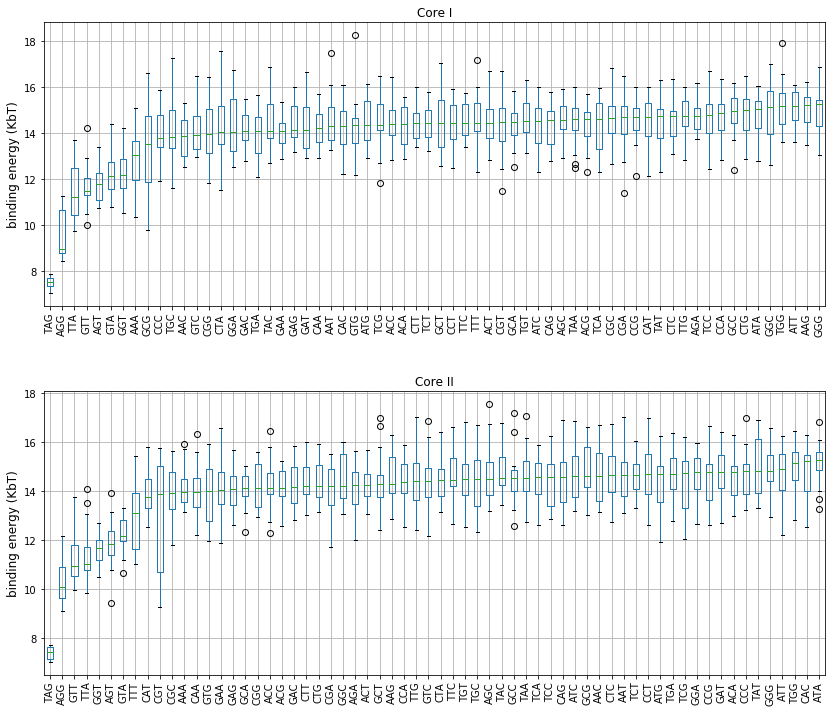

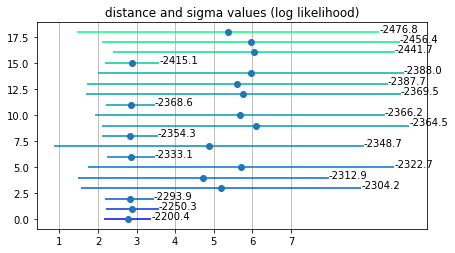

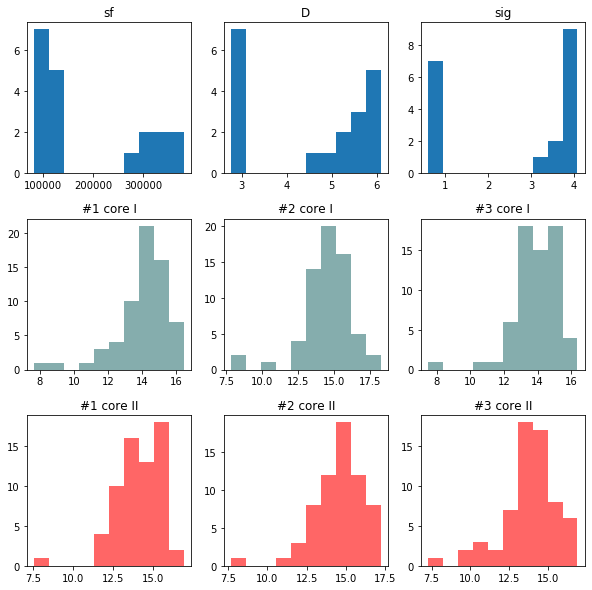

In [32]:
pdf = matplotlib.backends.backend_pdf.PdfPages("plots/summary_%s.pdf"%keyw)

#=== plot motifs =================
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(14,12))
plt.subplots_adjust(hspace=0.3)

core1.boxplot(ax=ax1, rot=90)
ax1.set_title('Core I', fontsize=12)
ax1.set_ylabel('binding energy (KbT)', fontsize=12)

core2.boxplot(ax=ax2, rot=90)
ax2.set_title('Core II', fontsize=12)
ax2.set_ylabel('binding energy (KbT)', fontsize=12)

pdf.savefig(fig)

#=====================

fig, ax = plt.subplots(1,1, figsize=(7,len(data)/5))
x = data.sort_values(by='LL')['D'].values
sig = data.sort_values(by='LL')['sig'].values

ll = -data.sort_values(by='LL')['LL'].values

cmap = matplotlib.cm.get_cmap('winter_r')
colors = (ll-min(ll))/(max(ll)-min(ll))
colors = [cmap(c) for c in colors]

y = np.array(np.arange(0,len(x),1))

ax.errorbar(x,y,xerr=sig, fmt='o', ecolor=colors)
ax.set_title('distance and sigma values (log likelihood)')
for i, llikelihood in enumerate(ll):
    ax.text(x[i]+sig[i], y[i], '%.1f'%llikelihood)

ax.grid(True, axis='x')
ax.set_xticks([int(x) for x in range(int(min(x))-1, int(max(x)) +2 )])

pdf.savefig(fig)

#== plot distance attributes and energy distribution ====

fig, axes = plt.subplots(3,3, figsize=(10,10))
plt.subplots_adjust(hspace=0.3)

ax1, ax2, ax3 = axes[0]

x1 = ax1.hist(data['sf'])
ax1.set_title('sf')

x2 = ax2.hist(data['D'])
ax2.set_title('D')

x3 = ax3.hist(data['sig'])
ax3.set_title('sig')

for i in range(3):
    axes[1][i].hist(core1.iloc[i,:],  color='#85adad')
    axes[1][i].set_title('#%d core I'%(i+1))
    
for i in range(3):
    axes[2][i].hist(core2.iloc[i,:], color='#ff6666')
    axes[2][i].set_title('#%d core II'%(i+1))

pdf.savefig(fig)


pdf.close()